# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc

from regression_abc import MDN, mdn_loss_function

import torch
from torch.autograd import Variable

## GMM example
Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [12]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

<IPython.core.display.Javascript object>


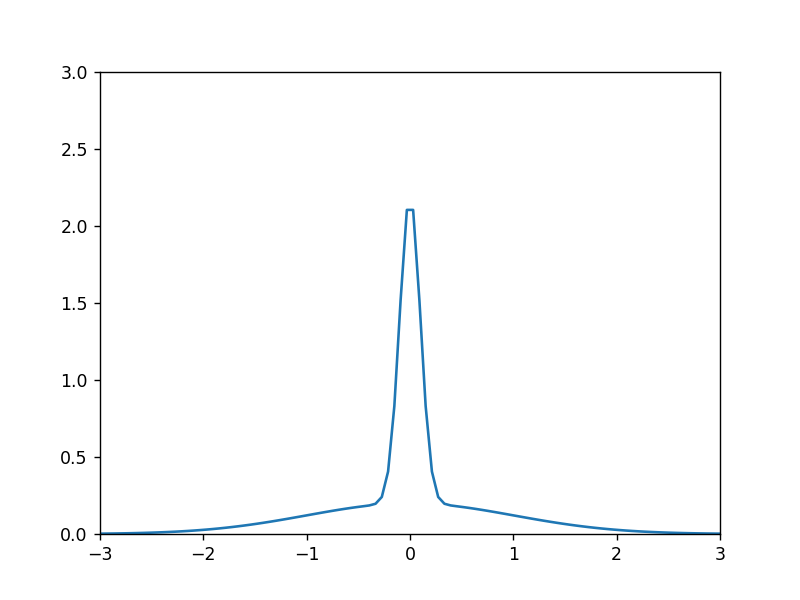

In [13]:
xx = np.linspace(-3,3,100)
plt.figure()
plt.plot(xx, posterior(xx))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In [23]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [14]:
NSAMPLE = 10_000

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(10000,)

In [15]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(10000,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [16]:
NHIDDEN = 20 # hidden units
KMIX = 2 # number of mixtures

Convert the training examples to torch tensors.

In [17]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

<IPython.core.display.Javascript object>


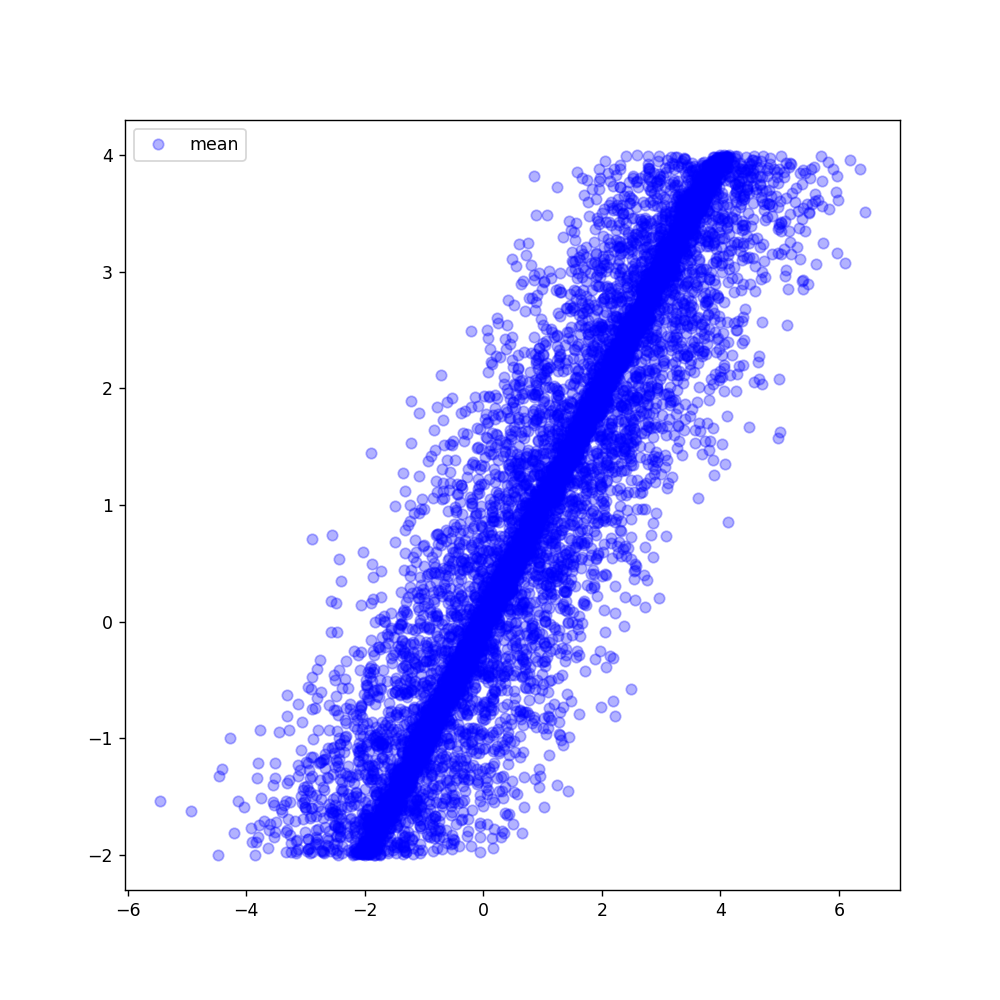

In [18]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [19]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [20]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 2.818746328353882
500 0.619036078453064
1000 0.5719980001449585
1500 0.5588894486427307
2000 0.5512745380401611
2500 0.5424860715866089
3000 0.5277553200721741
3500 0.5216761231422424
4000 0.5186418890953064
4500 0.5168285369873047
5000 0.5155085325241089
5500 0.514441967010498
6000 0.5135542750358582
6500 0.5128122568130493
7000 0.5121739506721497
7500 0.5115817189216614
8000 0.5109877586364746
8500 0.5104067921638489
9000 0.5098152160644531
9500 0.5093478560447693


In [24]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [60]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

out_pi = out_pi_test.data.numpy().T
out_sigma = out_sigma_test.data.numpy().T
out_mu = out_mu_test.data.numpy().T

In [62]:



def sample(x, n):
    (out_pi_test, out_sigma_test, out_mu_test) = model(x)
    
    out_pi = np.array([0.5, 0.5])[:,np.newaxis]
    out_mu = np.array([0, 5])
    out_sigma = np.array([1,1])[:,np.newaxis]

    out_pi = out_pi_test.data.numpy().T
    out_sigma = out_sigma_test.data.numpy().T
    out_mu = out_mu_test.data.numpy().T
    
    data = np.zeros((n, out_pi.size))
    
    num_distr= out_pi.size

    for idx, distr in enumerate(zip(out_mu, out_sigma)):
        mu, sigma = distr
        data[:, idx] = np.random.normal(mu, sigma, size=n)
    random_idx = np.random.choice(np.arange(num_distr), size=(n,), p=out_pi[:,0])
    sample = data[np.arange(n), random_idx]
    return sample

sample(x_test, 10)

array([0.48753433, 0.16489384, 0.33676651, 0.35437709, 0.5108504 ,
       0.33004718, 0.48156795, 0.1933185 , 0.54987487, 0.30200472])

In [25]:
xx = np.linspace(-3,3,100)

In [26]:
pdf = model.pdf(x_test, xx)

In [27]:
pdf.shape

(100,)

<IPython.core.display.Javascript object>


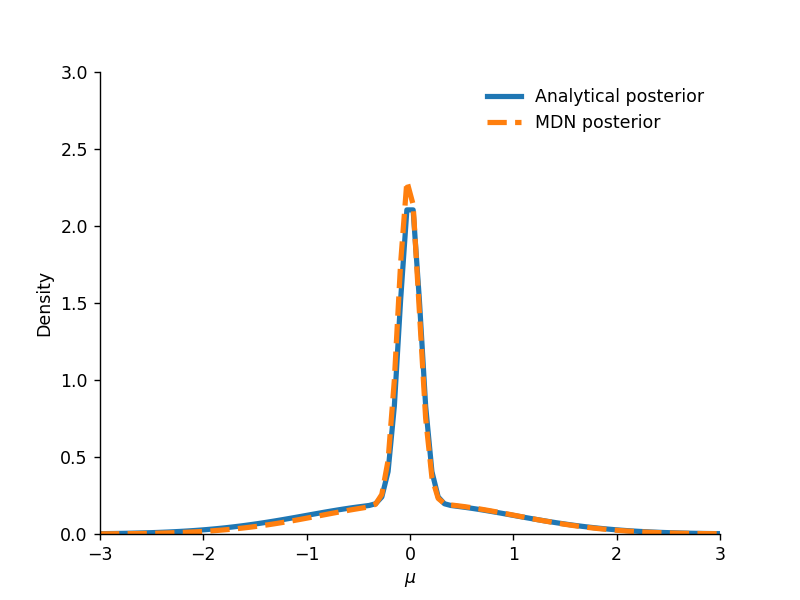

In [28]:
xx = np.linspace(-3,3,100)
f, ax = plt.subplots()
ax.plot(xx, posterior(xx), label='Analytical posterior', linewidth=3)
ax.plot(xx, pdf, label='MDN posterior', linewidth=3, linestyle='--')
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.legend(frameon=False)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('regression_abc_gmm.pdf')

## Tuberculosis example
First, we initialize the Tuberculosis transmission rate example. Load the simulator and observed data, then read the reference (Rejection ABC) posterior.

In [35]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

params = [alpha, tau, delta]

y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

# read reference (rejection ABC) posterior
rej = pyabc.RejectionSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/rej_10000_0.pkl')
rej.Thetas

xx = np.linspace(-0.2, 1.2, 100)

rej_thetas = rej.Thetas[:,0]
rej_kde = ss.kde.gaussian_kde(rej_thetas)
rej_dens = rej_kde(xx)

### Training the proposal prior
As Papamakarios & Murray (2016) note, learning the posterior directly while sampling from the prior is highly inefficient, since the posterior is learned for every $x$, not just for $x_0$. Thus, we first train a proposal prior, which is a one-dimensional Gaussian.

In [39]:
NHIDDEN = 50
INPUT_DIM = 20

proposal_mdn = MDN(hidden_size=NHIDDEN, num_mixtures=1, input_dim=INPUT_DIM)

<IPython.core.display.Javascript object>


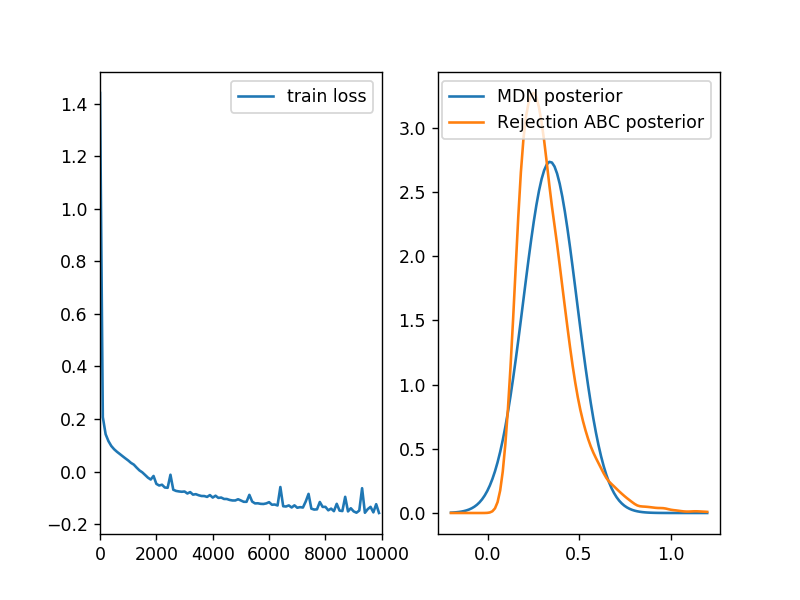

0 1.4401774406433105
100 0.20691949129104614
200 0.14201472699642181
300 0.11571870744228363
400 0.09737665206193924
500 0.08501219749450684
600 0.07536574453115463
700 0.06703250110149384
800 0.05853888764977455
900 0.0502239353954792
1000 0.042243074625730515
1100 0.03296829015016556
1200 0.026385894045233727
1300 0.014881938695907593
1400 0.0043482063338160515
1500 -0.002947008004412055
1600 -0.012956182472407818
1700 -0.023153085261583328
1800 -0.030338160693645477
1900 -0.016771037131547928
2000 -0.04691320285201073
2100 -0.05314174294471741
2200 -0.0501088984310627
2300 -0.06067122891545296
2400 -0.06186102330684662
2500 -0.01210153941065073
2600 -0.06913003325462341
2700 -0.07374319434165955
2800 -0.07561515271663666
2900 -0.0768928974866867
3000 -0.07590312510728836
3100 -0.08347563445568085
3200 -0.07817726582288742
3300 -0.0877794697880745
3400 -0.08602312207221985
3500 -0.09012783318758011
3600 -0.09300220012664795
3700 -0.09319167584180832
3800 -0.09636611491441727
3900 -0.

In [40]:
# number of samples per iteration
NSAMPLE = 500

# create initial training set from prior
alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

f, (loss_ax, dens_ax) = plt.subplots(1,2)

#for i in range(5):
learning_rate = 0.001
optimizer = torch.optim.Adam(proposal_mdn.parameters(), lr=learning_rate)
train_loss = []
for t in range(10_000):
    (out_pi, out_sigma, out_mu) = proposal_mdn(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)        
    if (t % 100 == 0):
        train_loss.append(loss.data[0])
        loss_ax.cla()
        loss_ax.plot(np.arange(t+1, step=100), train_loss, label="train loss")
        loss_ax.set_xlim((0,10_000))
        loss_ax.legend()

        dens_ax.cla()
        dens_ax.plot(xx, proposal_mdn.pdf(x_test, xx), label='MDN posterior')
        dens_ax.plot(xx, rej_dens, label='Rejection ABC posterior')
        dens_ax.legend()

        f.canvas.draw()
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [30]:
# create training set
NSAMPLE = 5000


# create training set
alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

# 'test example' (observed data point)
x_test = Variable(torch.from_numpy(np.array(y0).reshape(1, INPUT_DIM)).float())

In [33]:
NHIDDEN = 30
KMIX = 3

model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=INPUT_DIM)

<IPython.core.display.Javascript object>


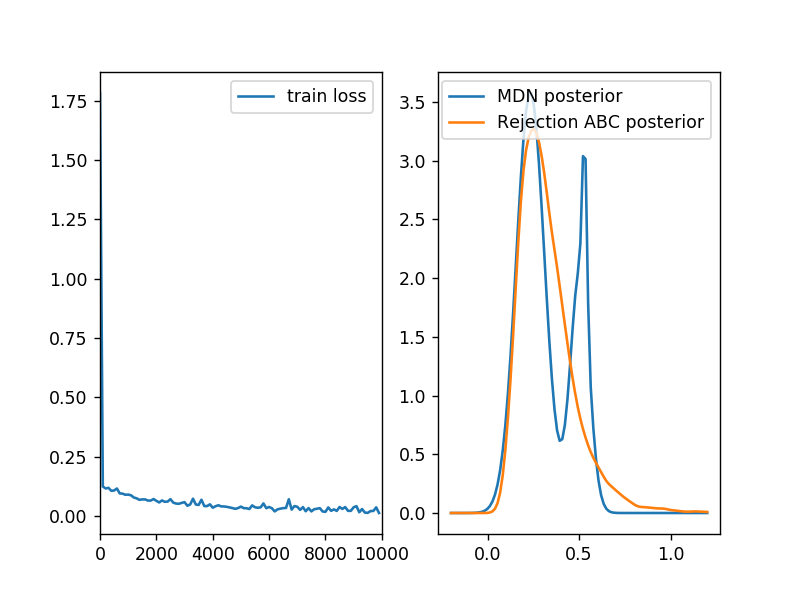

0 1.783174753189087
100 0.12452574074268341
200 0.11619769036769867
300 0.11899898201227188
400 0.10642717778682709
500 0.10765878111124039
600 0.11611094325780869
700 0.09540694952011108
800 0.09447440505027771
900 0.08971449732780457
1000 0.09057135134935379
1100 0.08755919337272644
1200 0.07816316187381744
1300 0.07469195872545242
1400 0.06830732524394989
1500 0.07028808444738388
1600 0.07013630867004395
1700 0.0653461366891861
1800 0.06520678848028183
1900 0.07171574234962463
2000 0.06415817141532898
2100 0.05740468576550484
2200 0.06577028334140778
2300 0.06011313199996948
2400 0.061058077961206436
2500 0.07118018716573715
2600 0.056498657912015915
2700 0.05264108628034592
2800 0.0517243929207325
2900 0.05555219575762749
3000 0.05859742313623428
3100 0.043411578983068466
3200 0.04873308166861534
3300 0.07311122864484787
3400 0.04865642637014389
3500 0.04679035022854805
3600 0.06883798539638519
3700 0.042062148451805115
3800 0.04210701957345009
3900 0.0493643544614315
4000 0.035294

In [34]:
f, (loss_ax, dens_ax) = plt.subplots(1,2)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
for t in range(10_000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)        
    if (t % 100 == 0):
        train_loss.append(loss.data[0])
        loss_ax.cla()
        loss_ax.plot(np.arange(t+1, step=100), train_loss, label="train loss")
        loss_ax.set_xlim((0,10_000))
        loss_ax.legend()
        
        dens_ax.cla()
        dens_ax.plot(xx, model.pdf(x_test, xx), label='MDN posterior')
        dens_ax.plot(xx, rej_dens, label='Rejection ABC posterior')
        dens_ax.legend()
        
        f.canvas.draw()
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<IPython.core.display.Javascript object>


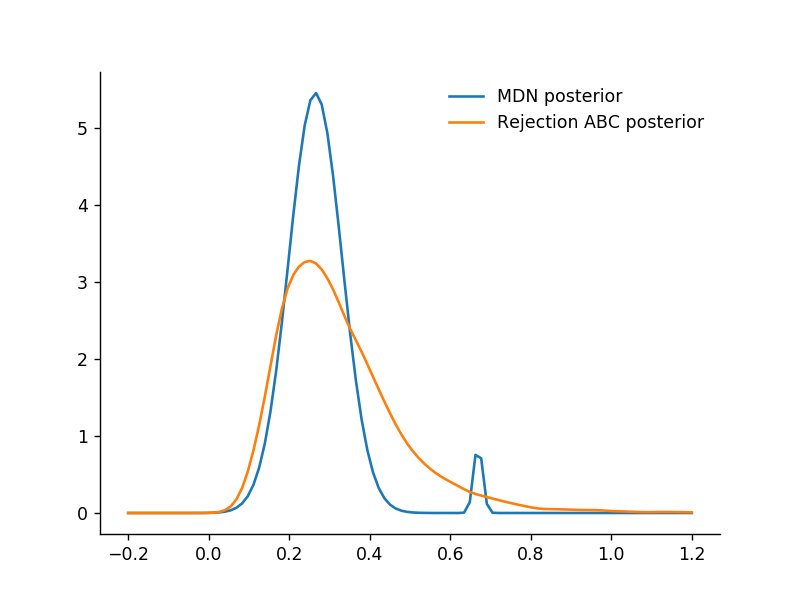

In [92]:
pdf = model.pdf(x_test, xx)

f, ax = plt.subplots()
ax.plot(xx, pdf, label='MDN posterior')
ax.plot(xx, rej_dens, label='Rejection ABC posterior')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.legend(frameon=False)